## Imports

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import os
from collections import defaultdict 
from nltk.corpus import stopwords

## Load Data

In [2]:
data_path = '../data/'
sen_names = pd.read_csv(os.path.join(data_path, "handles.csv"))
tweets = pd.read_csv(os.path.join(data_path, "tweets.csv"))
edges = pd.read_csv(os.path.join(data_path, "edges.csv"))

In [3]:
G = nx.DiGraph()

In [4]:
party_dict = dict(zip(sen_names["Name"], sen_names["Party"]))
for i in sen_names["Name"]:
    G.add_node(i, party = party_dict[i])
G.add_edges_from(list(zip(edges["followed"], edges["following"])))

## Graph Info (Basic)

In [5]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 100
Number of edges: 3912
Average in degree:  39.1200
Average out degree:  39.1200


C:\Users\Anurag\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\Anurag\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


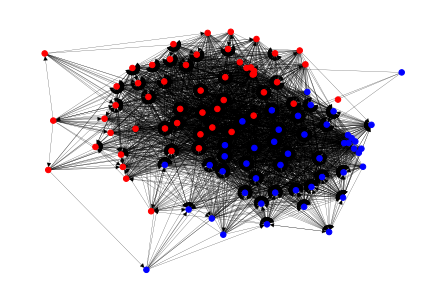

In [6]:
options = {
    'node_size': 30,
    'width': 0.2,
}
nx.draw_kamada_kawai(G, node_color = ['red' if i[1]['party'] == 'R' else 'blue' for i in G.nodes.data()], **options)

In [7]:
# Closeness centrality
closeness = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(list(zip(closeness.keys(), closeness.values())))

In [8]:
print("The highest closeness centrality:", max(closeness.values()))
print("The most important senator (highest centrality): WA Maria Cantwell")

The highest closeness centrality: 0.9604960496049605
The most important senator (highest centrality): WA Maria Cantwell


In [9]:
closeness_df
closeness_df.columns = ["Name", "Centrality"]
closeness_df["Party"] = closeness_df["Name"].apply(lambda x: party_dict[x])
closeness_df["Centrality"] = pd.to_numeric(closeness_df["Centrality"])
closeness_df.groupby("Party").max()

,Name,Centrality
Party,,
D,WV Joe Manchin III,0.960496
I,ME Susan M. Collins,0.881910
R,WY Michael B. Enzi,0.951079


In [11]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
voting_data = pd.read_csv(os.path.join(data_path, "voting.csv"))
dec_dict = dict(zip(list(set(voting_data["Decision"])), list(range(len(voting_data["Decision"])))))
voting_data["Decision"] = voting_data["Decision"].apply(lambda x : dec_dict[x])
voting_piv = pd.pivot_table(voting_data, index='Senator Name', columns='Bill')
voting_piv.head()

Decision                             ...                 \
Bill                       0  1  2  3  4  5  6  7  8  9   ... 69 70 71 72 73   
Senator Name                                              ...                  
AK Dan Sullivan             1  1  1  1  3  3  3  3  1  1  ...  1  1  1  1  1   
AK Lisa Murkowski           1  1  1  1  3  3  1  3  1  1  ...  1  1  1  1  1   
AL Doug Jones               1  1  1  1  1  1  1  3  1  1  ...  1  1  3  3  3   
AL Richard C. Shelby        1  1  1  1  3  3  3  3  1  1  ...  1  1  1  1  1   
AR John Boozman             1  1  1  1  3  3  3  3  1  1  ...  1  1  1  1  1   

                                     
Bill                 74 75 76 77 78  
Senator Name                         
AK Dan Sullivan       1  1  1  1  1  
AK Lisa Murkowski     1  1  1  1  1  
AL Doug Jones         3  3  3  3  3  
AL Richard C. Shelby  1  1  1  1  1  
AR John Boozman       1  1  1  1  1  

[5 rows x 79 columns]

In [ ]:
new = tweets.groupby("Senator Name").agg({"Tweets": sum})

In [ ]:
def pop_words(tweets):
    #generate top 1000 popular words
    tweets = tweets.groupby("Senator Name").agg({"Tweets": sum})
    total_words = defaultdict(int)
    stopWords = set(stopwords.words('english'))
    total_tweet = tweets["Tweets"].values
    for i in total_tweet:
        row_words = i.split()
        for j in row_words:
            j = j.lower()
            if j not in stopWords:
                total_words[j] += 1
    total_words = {key: val for key, val in sorted(total_words.items(), key = lambda ele: ele[1], reverse = True)}
    total_keys = total_words.keys()
    top_1000 = []
    count = 0
    for z in total_keys:
        top_1000.append(z)
        count += 1
        if count == 1000:
            break;
    id_1000 = dict(zip(top_1000, range(1000)))
    
    #create features
    feature = []
    for i in total_tweet:
        feat = [0]*1000
        row_words = i.split()
        for j in row_words:
            if j in top_1000:
                feat[id_1000[j]] += 1
        feature.append(feat)
    return feature

In [ ]:
feature = pop_words(tweets)